In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss


In [5]:
# Classifiers
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import KFold

In [6]:
data=pd.read_excel("D:\DATAS\ALDEN\DATA ALDEN.xlsx")
df=data.drop(columns='Kab')
df.head(2)

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17
0,1,1,60,1,2,1,7,7,1,5,5,1,5,5,2,83,13,0
1,1,1,54,1,2,1,7,7,1,5,5,5,5,5,4,80,3,0


In [7]:
x=df.drop(columns='Y')
y=df['Y']

In [8]:
x_insample, x_outsample, y_insample, y_outsample = train_test_split(x,y, test_size=0.1, random_state=42,shuffle=True)

In [9]:
# --- Define Models & Pipelines ---
models = {
    "LogisticRegression": Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000))
    ]),
    "SVC": Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(probability=True))
    ]),
    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    "MLP": Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(max_iter=500))
    ]),
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}


In [10]:
# --- Hyperparameter grids ---
param_distributions = {
    "LogisticRegression": {
        'lr__C': np.logspace(-3, 2, 10),
        'lr__penalty': ['l2'],
        'lr__solver': ['lbfgs', 'saga']
    },
    "SVC": {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf', 'poly'],
        'svc__gamma': ['scale', 'auto']
    },
    "KNN": {
        'knn__n_neighbors': [3,5,7,9],
        'knn__weights': ['uniform','distance'],
        'knn__metric': ['minkowski','euclidean','manhattan']
    },
    "MLP": {
        'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
        'mlp__activation': ['relu','tanh'],
        'mlp__alpha': [0.0001, 0.001, 0.01]
    },
    "GaussianNB": {},
    "MultinomialNB": {
        'alpha': [0.1,0.5,1.0]
    },
    "BernoulliNB": {
        'alpha': [0.1,0.5,1.0],
        'binarize': [0.0,0.5,1.0]
    }
}

In [11]:
# --- Cross-validation ---
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [12]:
# --- Train & Tune ---
best_models = {}
results = {}

In [15]:
for name, model in models.items():
    print(f"\nTuning {name}...")
    if param_distributions[name]:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions[name],
            n_iter=20,
            cv=cv,
            scoring='roc_auc',
            random_state=42,
            n_jobs=-1
        )
    else:
        search = model  # Model without hyperparameters

    search.fit(x_insample,y_insample)
    
    # Save best model
    best_models[name] = search.best_estimator_ if param_distributions[name] else search
    
    # Predictions
    y_pred = best_models[name].predict(x_outsample)
    try:
        y_proba = best_models[name].predict_proba(x_outsample)[:,1]
    except:
        y_proba = None
    
    # Metrics
    results[name] = {
        "Best Params": search.best_params_ if param_distributions[name] else None,
        "ROC-AUC": roc_auc_score(y_outsample, y_proba) if y_proba is not None else None,
        "Accuracy": accuracy_score(y_outsample, y_pred),
        "F1": f1_score(y_outsample, y_pred)
    }


Tuning LogisticRegression...

Tuning SVC...


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Tuning KNN...

Tuning MLP...


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=20. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterati


Tuning GaussianNB...

Tuning MultinomialNB...

Tuning BernoulliNB...


In [17]:
# --- Results DataFrame ---
results_df = pd.DataFrame(results).T
print(results_df)

                                                          Best Params  \
LogisticRegression  {'lr__solver': 'lbfgs', 'lr__penalty': 'l2', '...   
SVC                 {'svc__kernel': 'linear', 'svc__gamma': 'scale...   
KNN                 {'knn__weights': 'distance', 'knn__n_neighbors...   
MLP                 {'mlp__hidden_layer_sizes': (50,), 'mlp__alpha...   
GaussianNB                                                        NaN   
MultinomialNB                                          {'alpha': 0.5}   
BernoulliNB                           {'binarize': 1.0, 'alpha': 0.1}   

                     ROC-AUC  Accuracy        F1  
LogisticRegression  0.899569  0.874582  0.928639  
SVC                 0.879686  0.842809  0.914701  
KNN                 0.816046  0.859532  0.920304  
MLP                 0.868815  0.856187  0.917308  
GaussianNB          0.848045  0.575251  0.668407  
MultinomialNB       0.782738  0.704013       0.8  
BernoulliNB         0.798653   0.82107  0.893744  


In [18]:
results_df

,Best Params,ROC-AUC,Accuracy,F1
LogisticRegression,"{'lr__solver': 'lbfgs', 'lr__penalty': 'l2', '...",0.899569,0.874582,0.928639
SVC,"{'svc__kernel': 'linear', 'svc__gamma': 'scale...",0.879686,0.842809,0.914701
KNN,"{'knn__weights': 'distance', 'knn__n_neighbors...",0.816046,0.859532,0.920304
MLP,"{'mlp__hidden_layer_sizes': (50,), 'mlp__alpha...",0.868815,0.856187,0.917308
GaussianNB,NaN,0.848045,0.575251,0.668407
MultinomialNB,{'alpha': 0.5},0.782738,0.704013,0.8
BernoulliNB,"{'binarize': 1.0, 'alpha': 0.1}",0.798653,0.82107,0.893744


In [19]:
outsample_results = {}

for name, model in best_models.items():
    # Prediksi class dan probabilitas pada data outsample
    y_pred = model.predict(x_outsample)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_outsample)[:,1]  # <-- pastikan ini outsample
    else:
        y_proba = None

    outsample_results[name] = {
        "ROC-AUC": roc_auc_score(y_outsample, y_proba) if y_proba is not None else None,
        "Accuracy": accuracy_score(y_outsample, y_pred),
        "F1": f1_score(y_outsample, y_pred),
        "LogLoss": log_loss(y_outsample, y_proba) if y_proba is not None else None
    }

outsample_df = pd.DataFrame(outsample_results).T
outsample_df


,ROC-AUC,Accuracy,F1,LogLoss
LogisticRegression,0.899569,0.874582,0.928639,0.277633
SVC,0.879686,0.842809,0.914701,0.319666
KNN,0.816046,0.859532,0.920304,1.084524
MLP,0.868815,0.856187,0.917308,0.323064
GaussianNB,0.848045,0.575251,0.668407,1.953732
MultinomialNB,0.782738,0.704013,0.800000,0.868302
BernoulliNB,0.798653,0.821070,0.893744,0.371340


In [20]:
# Fungsi evaluasi model
def evaluate_model_stats(model, x_train, y_train, x_test, y_test, n_rademacher=100):
    """
    Menghitung 3 statistik:
    - Rademacher complexity (aproksimasi sederhana)
    - Hoeffding excess risk
    - Gap risk
    """
    # Prediksi
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # 1. Rademacher complexity (aproksimasi sederhana)
    n_samples = x_train.shape[0]
    rademacher_scores = []
    for _ in range(n_rademacher):
        sigma = np.random.choice([-1, 1], size=n_samples)
        score = np.mean(sigma * (y_train_pred == y_train))
        rademacher_scores.append(score)
    rademacher_complexity = np.mean(np.abs(rademacher_scores))

    # 2. Hoeffding excess risk
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    hoeffding_excess_risk = train_acc - test_acc

    # 3. Gap risk
    gap_risk = test_acc - train_acc

    return {
        "Rademacher Complexity": rademacher_complexity,
        "Hoeffding Excess Risk": hoeffding_excess_risk,
        "Gap Risk": gap_risk,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc
    }

# Evaluasi semua model di best_models
stats_df = pd.DataFrame({
    name: evaluate_model_stats(model, x_insample, y_insample, x_outsample, y_outsample)
    for name, model in best_models.items()
}).T

print(stats_df)


                    Rademacher Complexity  Hoeffding Excess Risk  Gap Risk  \
LogisticRegression               0.008790              -0.004094  0.004094   
SVC                              0.011474               0.010931 -0.010931   
KNN                              0.010878               0.140468 -0.140468   
MLP                              0.010782               0.045562 -0.045562   
GaussianNB                       0.007603              -0.039337  0.039337   
MultinomialNB                    0.009226               0.001792 -0.001792   
BernoulliNB                      0.009378              -0.014222  0.014222   

                    Train Accuracy  Test Accuracy  
LogisticRegression        0.870488       0.874582  
SVC                       0.853740       0.842809  
KNN                       1.000000       0.859532  
MLP                       0.901749       0.856187  
GaussianNB                0.535914       0.575251  
MultinomialNB             0.705806       0.704013  
BernoulliNB

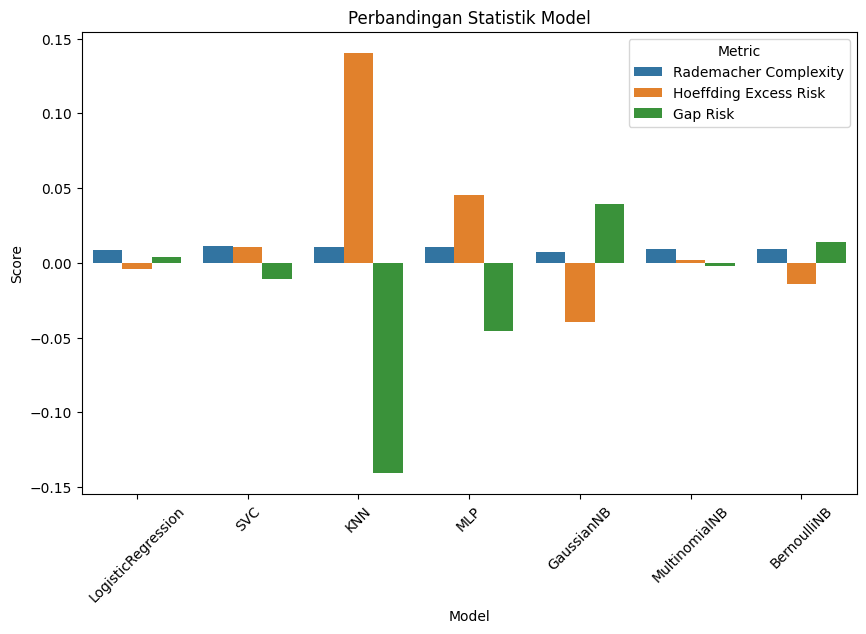

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ubah ke format long
plot_df = stats_df.reset_index().melt(
    id_vars="index",
    value_vars=["Rademacher Complexity", "Hoeffding Excess Risk", "Gap Risk"],
    var_name="Metric",
    value_name="Score"
)

plot_df.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x="Model", y="Score", hue="Metric")
plt.title("Perbandingan Statistik Model")
plt.xticks(rotation=45)
plt.show()
